# Solution decision tree algorithm

## Customization and import

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

## Data analysis and Dataset Preparation

In [246]:
df_rating = pd.read_csv("../input/book-recommendation-dataset/Ratings.csv")
print(df_rating.shape)
df_rating.head()

(1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [247]:
df_book = pd.read_csv("../input/book-recommendation-dataset/Books.csv")
print(df_book.shape)
df_book.head(2)

(271360, 8)


C:\Users\Mi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3106: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [248]:
df_user = pd.read_csv("../input/book-recommendation-dataset/Users.csv")
print(df_user.shape)
df_user.head(2)

(278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


In [249]:
df_user.columns = df_user.columns.str.lower().str.strip().str.replace("-", "_")
df_book.columns = df_book.columns.str.lower().str.strip().str.replace("-", "_")
df_rating.columns = df_rating.columns.str.lower().str.strip().str.replace("-", "_")
print(df_user.columns)
print(df_rating.columns)
print(df_book.columns)

Index(['user_id', 'location', 'age'], dtype='object')
Index(['user_id', 'isbn', 'book_rating'], dtype='object')
Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
       'image_url_s', 'image_url_m', 'image_url_l'],
      dtype='object')


In [250]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [251]:
print(df_user.duplicated().sum())
print(df_user["age"].isnull().sum())

0
110762


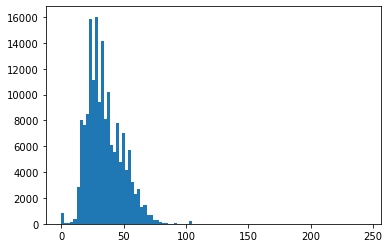

In [252]:
plt.hist(df_user.age, bins=100)

In [253]:
df_user.describe()["age"]

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: age, dtype: float64

In [254]:
df_userdp = df_user.copy()

age_mean = df_user["age"].mean()
print(age_mean)

df_userdp["age"] = df_userdp["age"].replace(np.nan, age_mean)

34.75143370454978


In [255]:
out_index = df_userdp[(df_userdp["age"] < 14) | (df_userdp["age"] > 100)].index

df_userdp.loc[out_index, "age"] = age_mean

In [256]:
df_userdp.describe()["age"]

count    278858.000000
mean         34.869245
std          10.411870
min          14.000000
25%          30.000000
50%          34.751434
75%          35.000000
max         100.000000
Name: age, dtype: float64

In [257]:
print(df_rating.isnull().sum())
print(df_book.isnull().sum())

user_id        0
isbn           0
book_rating    0
dtype: int64
isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
image_url_s            0
image_url_m            0
image_url_l            3
dtype: int64


In [258]:
print(len(df_user["location"].unique()))

loc = df_user["location"].values

57339


In [259]:
country = []
for i in loc:
    country.append(i.split()[-1])
print(len(country))
country[:5]

278858


['usa', 'usa', 'russia', 'portugal', 'kingdom']

In [260]:
df_userdp["country"] = country
df_userdp.head()

,user_id,location,age,country
0,1,"nyc, new york, usa",34.751434,usa
1,2,"stockton, california, usa",18.000000,usa
2,3,"moscow, yukon territory, russia",34.751434,russia
3,4,"porto, v.n.gaia, portugal",17.000000,portugal
4,5,"farnborough, hants, united kingdom",34.751434,kingdom


In [261]:
df_userco = df_userdp.copy()

df_userco["country"] = df_userco["country"].replace("kingdom", "uk")
df_userco.head()

,user_id,location,age,country
0,1,"nyc, new york, usa",34.751434,usa
1,2,"stockton, california, usa",18.000000,usa
2,3,"moscow, yukon territory, russia",34.751434,russia
3,4,"porto, v.n.gaia, portugal",17.000000,portugal
4,5,"farnborough, hants, united kingdom",34.751434,uk


In [262]:
df_userco["age"] = df_userco["age"].astype("int32")

df_userco.dtypes

user_id      int64
location    object
age          int32
country     object
dtype: object

In [263]:
df_userfin = df_userco.drop(["location"], axis=1)
df_userfin.head()

print(len(df_userfin.country.unique()))

1065


In [264]:
df_userfin["country"].value_counts()[110:140]

honduras          27
kenya             27
antarctica        27
lombardia,        26
bermuda           26
massachusetts,    26
salvador          26
netherlands"      26
oman              26
florida,          25
uzbekistan        24
zimbabwe          24
washington,       24
islands           23
belize            23
zealand"          23
ohio,             23
oregon,           22
estonia           22
jordan            22
rico              21
nepal             21
uruguay           20
missouri,         20
mauritius         20
finland"          20
michigan,         19
qatar             19
grenada           19
u.a.e             19
Name: country, dtype: int64

In [265]:
df_userfin["country"] = df_userfin["country"].replace(",", "usa")

df_userfin["country"].describe()

count     278858
unique      1064
top          usa
freq      142602
Name: country, dtype: object

In [266]:
data = df_userfin["country"].values
data[:5]

array(['usa', 'usa', 'russia', 'portugal', 'uk'], dtype=object)

In [267]:
for i, x in enumerate(data):
    if "," in x:
        data[i] = x[:-1]
for j, y in enumerate(data):
    if "," in y:
        data[j] = "usa"
for i, x in enumerate(data):
    if '"' in x:
        data[i] = x[:-1]
for i, x in enumerate(data):
    if ("," in x) | ('"' in x):
        data[i] = "usa"

In [268]:
df_userfin["set_country"] = data

df_userfin.head()

print(len(df_userfin["set_country"].unique()))

df_userfin = df_userfin.drop(["country"], axis=1)

896


In [269]:
df_ratus = pd.merge(df_rating, df_userfin)
df_all = pd.merge(df_ratus, df_book)
df_all.head()

,user_id,isbn,book_rating,age,set_country,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
0,276725,034545104X,0,34,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,23,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,34,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,34,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,34,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [270]:
df_all = df_all.iloc[:, :-3]

In [271]:
df_all.head()

,user_id,isbn,book_rating,age,set_country,book_title,book_author,year_of_publication,publisher
0,276725,034545104X,0,34,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5,23,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,6543,034545104X,0,34,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
3,8680,034545104X,5,34,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
4,10314,034545104X,9,34,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


In [272]:
df_all.sort_values(by=["book_rating"], ascending=False).head(5)

,user_id,isbn,book_rating,age,set_country,book_title,book_author,year_of_publication,publisher
195707,59172,0446364762,10,36,canada,The Stars Shine Down,Sidney Sheldon,1993,Warner Books
316032,183883,0440180295,10,35,usa,Slaughterhouse Five or the Children's Crusade:...,Kurt Vonnegut,1991,Laurel
728400,131317,1565048709,10,34,usa,Zod Wallop,William Browning Spencer,1997,White Wolf Pub
316075,252222,0440180295,10,21,canada,Slaughterhouse Five or the Children's Crusade:...,Kurt Vonnegut,1991,Laurel
491302,11676,0786926813,10,34,n/a,Dragonlance Chronicles Trilogy Gift Set,Margaret Weis,2001,Wizards of the Coast


In [273]:
print(len(df_all["publisher"].unique()))
print(len(df_all["book_author"].unique()))
df_all["book_rating"].unique()
df = df_all.copy()

16730
101589


In [274]:
df.dtypes

user_id                 int64
isbn                   object
book_rating             int64
age                     int32
set_country            object
book_title             object
book_author            object
year_of_publication    object
publisher              object
dtype: object

In [275]:
isbn_enc = LabelEncoder()
isbn_enc.fit(df["isbn"].unique())
df["isbn"] = isbn_enc.transform(df["isbn"])

In [276]:
le = LabelEncoder()
names = ["set_country", "book_title", "book_author", "publisher"]

for i in names:
    df[i] = le.fit_transform(df[i].astype(str))

In [277]:
ind = df[df["year_of_publication"] == "DK Publishing Inc"].index
df.loc[ind, ["year_of_publication"]] = 2002
df.loc[
    df[df["year_of_publication"] == "Gallimard"].index, ["year_of_publication"]
] = 2002
df["year_of_publication"] = df["year_of_publication"].astype(int)

In [278]:
data = df.drop(["book_rating"], axis=1)
label = df["book_rating"]

In [279]:
X_train, X_test, y_train, y_test = train_test_split(
    data, label, test_size=0.2, random_state=42
)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(824908, 8) (824908,)
(206228, 8) (206228,)


## Model

In [280]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=20)
tree.fit(X_train.values, y_train.values)

y_hat = tree.predict(X_test)
print(y_hat[:5])
print(y_hat.shape)

print("test:", metrics.accuracy_score(y_test, y_hat))
print("train:", metrics.accuracy_score(y_train, tree.predict(X_train)))

C:\Users\Mi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Mi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


[ 0  0 10  0  0]
(206228,)
test: 0.6074150939736602
train: 0.7278157079334908


In [281]:
rating = np.array(df["book_rating"])
liked = np.zeros(rating.shape[0])
print(rating.shape, liked.shape)

for i in range(len(rating)):
    if rating[i] > 6:
        liked[i] = 1
    else:
        liked[i] = 0
print(liked[:5])

(1031136,) (1031136,)
[0. 0. 0. 0. 1.]


In [282]:
X_train, X_test, y_train, y_test = train_test_split(
    data, liked, test_size=0.2, random_state=42
)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(824908, 8) (824908,)
(206228, 8) (206228,)


## Training

In [283]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=15)
tree.fit(X_train.values, y_train)

y_hat = tree.predict(X_test)
print(y_hat[:5])
print(y_hat.shape)

print("test:", metrics.accuracy_score(y_test, y_hat))
print("train:", metrics.accuracy_score(y_train, tree.predict(X_train)))

C:\Users\Mi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Mi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


[0. 0. 1. 0. 0.]
(206228,)
test: 0.7287031828849623
train: 0.7440429720647636


In [284]:
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(data, liked)


dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data.columns)

featurescores = pd.concat([dfscores, dfcolumns], axis=1)

featurescores.columns = ["scores", "feature"]

In [285]:
featurescores.nlargest(8, "scores")

,scores,feature
0,7.641242e+07,user_id
1,3.321029e+07,isbn
5,1.383029e+05,book_author
3,2.605263e+04,set_country
7,1.809507e+04,publisher
6,1.385075e+03,year_of_publication
2,5.543276e+02,age
4,9.589359e+01,book_title


In [286]:
data_feat = data[["user_id", "isbn", "book_author", "set_country", "publisher"]]

In [287]:
X_train, X_test, y_train, y_test = train_test_split(
    data_feat, liked, test_size=0.2, random_state=42
)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(824908, 5) (824908,)
(206228, 5) (206228,)


In [288]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=15)
tree.fit(X_train.values, y_train)

y_hat = tree.predict(X_test)
print(y_hat[:5])
print(y_hat.shape)

print("test:", metrics.accuracy_score(y_test, y_hat))
print("train:", metrics.accuracy_score(y_train, tree.predict(X_train)))

C:\Users\Mi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Mi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


[0. 0. 1. 0. 0.]
(206228,)
test: 0.7290571600364645
train: 0.7426270565929777


In [289]:
liked = pd.DataFrame(y_hat, columns=["liked"])
print(liked.shape)
print(X_test.shape)

(206228, 1)
(206228, 5)


## Testing

In [290]:
X = X_test.copy()

X.set_index(liked.index)

X.reset_index(drop=True, inplace=True)
liked.reset_index(drop=True, inplace=True)

end = pd.concat([X, liked], axis=1)

end.head()

,user_id,isbn,book_author,set_country,publisher,liked
0,162886,149755,38969,302,6654,0.0
1,11676,36791,80798,255,14026,0.0
2,78973,121709,18364,302,1414,1.0
3,14521,118284,83391,387,1418,0.0
4,277427,36058,66152,387,14028,0.0


In [301]:
end["no"] = isbn_enc.inverse_transform(end["isbn"])

u = end[end["liked"] == 1]["user_id"].unique()
mask = (end["liked"] == 1) & (end["user_id"] == u[0])

recommend = end[mask]["no"]
recommend

select = np.array(recommend)

In [303]:
df_book[df_book["isbn"].isin(select)].head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
136,0671004573,Before I Say Good-Bye,Mary Higgins Clark,2001,Pocket,http://images.amazon.com/images/P/0671004573.0...,http://images.amazon.com/images/P/0671004573.0...,http://images.amazon.com/images/P/0671004573.0...
154,0140252800,The Brimstone Wedding,Barbara Vine,1997,Penguin Books Ltd,http://images.amazon.com/images/P/0140252800.0...,http://images.amazon.com/images/P/0140252800.0...,http://images.amazon.com/images/P/0140252800.0...
281,0440241413,Confessions of a Shopaholic,SOPHIE KINSELLA,2003,Dell,http://images.amazon.com/images/P/0440241413.0...,http://images.amazon.com/images/P/0440241413.0...,http://images.amazon.com/images/P/0440241413.0...
763,0743206045,Daddy's Little Girl,Mary Higgins Clark,2002,Simon &amp; Schuster,http://images.amazon.com/images/P/0743206045.0...,http://images.amazon.com/images/P/0743206045.0...,http://images.amazon.com/images/P/0743206045.0...
995,0425166619,Toxin,Robin Cook,1999,Berkley Publishing Group,http://images.amazon.com/images/P/0425166619.0...,http://images.amazon.com/images/P/0425166619.0...,http://images.amazon.com/images/P/0425166619.0...
